In [2]:
import random
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
words = open("words_alpha.txt", "r").read().splitlines()

words[1:10]

['aa', 'aaa', 'aah', 'aahed', 'aahing', 'aahs', 'aal', 'aalii', 'aaliis']

In [45]:
len(words)

370104

In [46]:
# lookup tables

characters = sorted(list(set("".join(words))))
stoi = {s : i + 1 for i, s in enumerate(characters)}
stoi["."] = 0
itos = {i : s for s, i in stoi.items()}

vocab_size = 27

In [47]:
# building the dataset
random.seed(2)
block_size = 3 # how many chars used to predict the next character

def build_dataset(words):
    X, y = [], []

    for w in words:
        context = [0] * block_size # start characters in the start
        for ch in w + '.':
            ix = stoi[ch] 
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix] # crop and append 

    X = torch.tensor(X)
    y = torch.tensor(y)
    
    return X, y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])


In [133]:
g = torch.Generator().manual_seed(5)
n_dims = 10
n_hidden = 100

# encoding alphabets into n_dims-dim space
C = torch.randn((vocab_size, n_dims), generator = g)
W1 = torch.randn(((block_size * n_dims), n_hidden), generator = g) * ((5/3) / (block_size * n_dims) ** 0.5) 
# hidden layer 1                                                    manual kaiming_init (multiplying by gain)
#b1 = torch.randn(n_hidden, generator = g) * 0.01 
#no need to use anymore since we are batch normalizing and that subtracts biases anyway
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.1  # output layer
b2 = torch.zeros(vocab_size)
# b2 = torch.randn(vocab_size, generator = g)
# for batch normalization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True
    
# batch normalization is done to control the statistics of layers in which there are multiplications. 
# usually sprinkled in after layers with multiplications, linear layers, convolutional layers. done using 
# a gain and bias that are learned during training, and running mean and std that are updated during training 
# (not learned). hard to work with tho, group normalization/layer normalization might be better. 

In [134]:
# training!!!

# lri = []
# lossi = []
# stepi = []

max_runs = 100000
mini_batch_size = 32

for i in range(max_runs):
    # make minibatches for more efficiency
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size, ))
    
    # forward pass
    emb = C[X_train[ix]] # indexing using X
    embcat = emb.view(emb.shape[0], -1)
    hpreact = (embcat @ W1) #+ b1
    bnmean_i = hpreact.mean(0, keepdims = True)
    bnstd_i = hpreact.std(0, keepdims = True)
    hpreact = bngain * ((hpreact - bnmean_i) / bnstd_i) + bnbias
    h = torch.tanh(hpreact)
    logits = ((h @ W2) + b2)
    loss = F.cross_entropy(logits, y_train[ix])
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
        bnstd_running = 0.99 * bnstd_running + 0.01 * bnstd_i
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # lr = lre[i]    
    lr = 0.01 if i < (max_runs / 2) else 0.001 # learning rate decay
    # update
    for p in parameters:
        p.data += -lr * p.grad
    
    print(f'Run {i}/{max_runs - 1}, Loss: {loss}') if (((i % (max_runs / 10)) == 0) or (i == max_runs - 1)) else ""
    # lri.append(lr)
    # lossi.append(loss.item())
    # stepi.append(i)

Run 0/99999, Loss: 3.312075614929199
Run 10000/99999, Loss: 2.4320058822631836
Run 20000/99999, Loss: 2.6608364582061768
Run 30000/99999, Loss: 2.5180511474609375
Run 40000/99999, Loss: 2.5870609283447266
Run 50000/99999, Loss: 2.2551257610321045
Run 60000/99999, Loss: 2.0536718368530273
Run 70000/99999, Loss: 2.7473251819610596
Run 80000/99999, Loss: 2.3807363510131836
Run 90000/99999, Loss: 1.984889030456543
Run 99999/99999, Loss: 2.2277638912200928


In [137]:
# dev loss
emb = C[X_dev]
embcat = emb.view(emb.shape[0], -1)
hpreact = (embcat @ W1) #+ b1
#hpreact = bngain * ((hpreact - hpreact.mean(0, keepdims = True)) / hpreact.std(0, keepdims = True)) + bnbias 
#                           causes coupling bw examples (bad)
hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias 
h = torch.tanh(hpreact)
logits = ((h @ W2) + b2)
loss = F.cross_entropy(logits, y_dev)
loss

tensor(2.3501, grad_fn=<NllLossBackward0>)

In [138]:
# test loss

emb = C[X_test]
embcat = emb.view(emb.shape[0], -1)
hpreact = (embcat @ W1) #+ b1
hpreact = bngain * ((hpreact - hpreact.mean(0, keepdims = True)) / hpreact.std(0, keepdims = True)) + bnbias
h = torch.tanh(hpreact)
logits = ((h @ W2) + b2)
loss = F.cross_entropy(logits, y_test)
loss

tensor(2.3495, grad_fn=<NllLossBackward0>)

Training loss ~ Test loss means underfitting, could benefit from scaling up

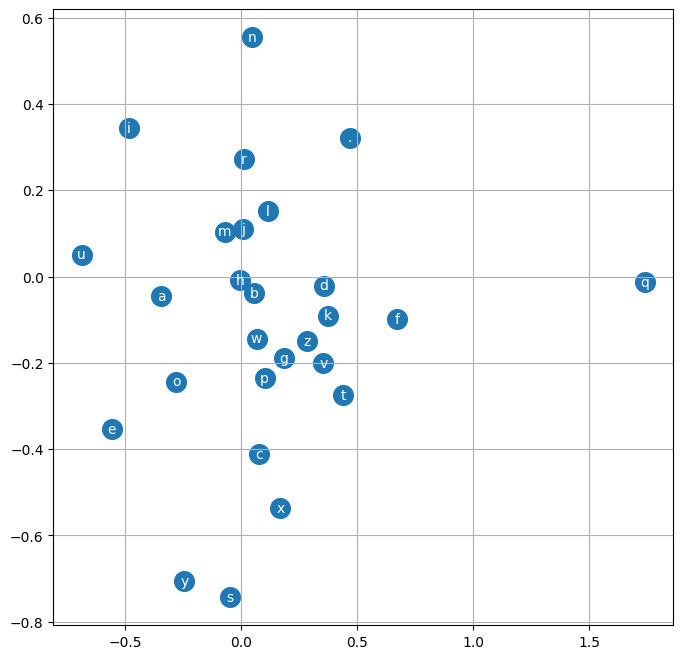

In [171]:
# plot of 2d embeddings for each character

plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = "center", va = "center", color = "white")
    plt.grid("minor")

SO INTERESTING TO SEE VOWELS CLUSTERED TOGETHER, AND HOW EVERYTHING SORT OF MAKES SENSE

In [170]:
# sampling

words = []

for i in range(10):
  context = [0] * block_size
  
  while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh((emb.view(1, -1) @ W1) + b1)
      logits = (h @ W2) + b2
      probs = F.softmax(logits, dim = 1)
      ix = torch.multinomial(probs, num_samples = 1).item()
      context = context[1:] + [ix]
      words.append(itos[ix])
      if (ix == 0):
          break 
      
print("".join(words))

dems.perush.seprrexing.qamtes.frats.deucufoxrydodg.qasth.pruvonfzivluftry.but.princtspfoxxuominppuints.


: 

Way better results lmao

Doing the same thing, but in a more pytorch way

In [ ]:
class Linear:
    def __init__(self, num_in, num_out, bias = True):
        self.weight = torch.randn((num_in, num_out)) / (num_in ** (1/2))
        self.bias = torch.zeros(num_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1D:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.rmean = torch.zeros(dim)
        self.rvar = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.rmean
            xvar = self.var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.rmean = (1 - self.momentum) * self.rmean + self.momentum * xmean
                self.rvar = (1 - self.momentum) * self.rvar + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
            